In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


In [11]:
# Load the data
data = pd.read_csv('Palette_Training_5-main/rm_crop_yields_1938_2021.csv', encoding='utf-8')

In [12]:
# Pre-process the data
data.fillna(0, inplace = True)
X = data.drop('Year', axis = 1).values
y = data['Year'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standardize the data using minmax scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model 
# We will use a Ridge Regression model
model = Ridge()
model.fit(X_train, y_train)

# Test the model
score = model.score(X_test, y_test)

# Use grid search to find the optimal hyperparameters
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(model, parameters, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the optimal parameters
print('Optimal parameters: {}'.format(grid_search.best_params_))

# Print the best score achieved
print('Best score: {}'.format(grid_search.best_score_))

Optimal parameters: {'alpha': 0.1}
Best score: 0.7615436531601724


In [15]:
# find the learning rate
learning_rate = grid_search.best_params_['alpha']

# Train the model with the optimal hyperparameters
model = Ridge(alpha=learning_rate)
model.fit(X_train, y_train)

# Test the model
score = model.score(X_test, y_test)

# Print the score
print('Score: {}'.format(score))

Score: 0.7659522654949908


In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.special import boxcox1p
import missingno as msno
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) #Limiting floats output to 3 decimal points
pd.set_option("display.max_columns", None)


In [29]:
trainingset = data
testset = pd.read_csv("Palette_Training_5-main/rm_crop_yields_1938_2021.csv")
o_submission = pd.read_csv("Palette_Training_5-main/submission.csv")

In [30]:
# Spliting Data
#X = df4.drop(["RM"], axis=1)
X = data
#y = df4['RM']
y = data['Canola']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("{}{}{}{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

(20013, 18)(20013,)(5004, 18)(5004,)


In [31]:
result = {}
def evaluation(y, y_pred):
    r_squared = r2_score(y, y_pred),
    mae = mean_absolute_error(y, y_pred),
    mse = mean_squared_error(y, y_pred),
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r_squared, mae, mse, rmse

In [32]:
low_cardinality_cols = [col for col in X_train.columns if (X_train[col].dtype=="object") & (X_train[col].nunique()<26)]
#print(len(low_cardinality_cols), low_cardinality_cols)

column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False),low_cardinality_cols),
    remainder='passthrough'
)
sc = StandardScaler()

In [33]:
test_X = data

In [36]:
model = Lasso(alpha=0.0014) 
pipe = make_pipeline(column_trans, sc, model) 
pipe.fit(X_train, y_train)
predictions = pipe.predict(test_X)
predictions = np.exp(predictions) #inverse logrithm on predicted SalePrice.
pd.DataFrame(predictions.reshape(len(predictions),1)).describe()

,0
count,25017.000
mean,4141408391530662068224.000
std,445880540783745723006976.000
min,1.002
25%,1.002
50%,1202101.213
75%,26457076660.561
max,68718406452092695866245120.000


In [38]:
model = Lasso() 
pipe = make_pipeline(column_trans, sc, model) 
params = {"lasso__alpha": np.arange(0.0008,0.002,0.0001)} #print(pipe.get_params().keys())
cv_lasso = GridSearchCV(pipe, param_grid=params)
cv_lasso.fit(X_train, y_train)
preds_lasso = cv_lasso.predict(X_test)
preds_lasso = np.exp(preds_lasso) #inverse logrithm on predicted SalePrice.
lasso_r2, lasso_mae, lasso_mse, lasso_rmse = evaluation(y_test, preds_lasso) 
print(cv_lasso.best_params_, cv_lasso.best_score_)

{'lasso__alpha': 0.0009000000000000001} 0.99999998459504


In [39]:
model = Ridge() 
pipe = make_pipeline(column_trans, sc, model) 
params = {"ridge__alpha": np.arange(1,100,10)} #print(pipe.get_params().keys())
cv_ridge = GridSearchCV(pipe, param_grid=params)
cv_ridge.fit(X_train, y_train)
preds_ridge = cv_ridge.predict(X_test)
preds_ridge = np.exp(preds_ridge) #inverse logrithm on predicted SalePrice.
print(cv_ridge.best_params_, cv_ridge.best_score_)

{'ridge__alpha': 1} 0.999999982202449


In [40]:
model = ElasticNet()
pipe = make_pipeline(column_trans, sc, model) 
#print(pipe.get_params().keys())
params = {"elasticnet__alpha": np.arange(0,0.2,0.01)} 
cv_elastic = GridSearchCV(pipe, param_grid=params)
cv_elastic.fit(X_train, y_train)
preds_elastic = cv_elastic.predict(X_test)
preds_elastic = np.exp(preds_elastic) #inverse logrithm on predicted SalePrice.
print(cv_elastic.best_params_, cv_elastic.best_score_)

{'elasticnet__alpha': 0.0} 0.9999999167883262


In [41]:
model = RandomForestRegressor()
pipe = make_pipeline(column_trans, model) 
#print(pipe.get_params().keys())
params = {"randomforestregressor__n_estimators": np.arange(50,150,50)} 
cv_rf = GridSearchCV(pipe, param_grid=params)
cv_rf.fit(X_train, y_train)
preds_rf = cv_rf.predict(X_test)
preds_rf = np.exp(preds_rf) #inverse logrithm on predicted SalePrice.
pd.DataFrame(preds_rf.reshape(len(preds_rf),1)).describe()
print(cv_rf.best_params_, cv_rf.best_score_)

{'randomforestregressor__n_estimators': 50} 0.999996000583217


In [42]:
model = XGBRegressor()
pipe = make_pipeline(column_trans, model) 
#print(pipe.get_params().keys())
params = {"xgbregressor__n_estimators": np.arange(100,200,50), "xgbregressor__learning_rate": np.arange(0.08,0.12,0.01)} 
cv_xg = GridSearchCV(pipe, param_grid=params)
cv_xg.fit(X_train, y_train)
preds_xg = cv_xg.predict(X_test)
preds_xg = np.exp(preds_xg) #inverse logrithm on predicted SalePrice.
pd.DataFrame(preds_xg.reshape(len(preds_xg),1)).describe()
print(cv_xg.best_params_, cv_xg.best_score_)

{'xgbregressor__learning_rate': 0.08, 'xgbregressor__n_estimators': 150} 0.9999950535196425


In [43]:
model = SVR()
pipe = make_pipeline(column_trans, sc, model) 
#print(pipe.get_params().keys())
params = {"svr__C": np.arange(1,1.6,0.1)} 
cv_svr = GridSearchCV(pipe, param_grid=params)
cv_svr.fit(X_train, y_train)
preds_svr = cv_svr.predict(X_test)
preds_svr = np.exp(preds_svr) #inverse logrithm on predicted SalePrice.
print(cv_svr.best_params_, cv_svr.best_score_)

{'svr__C': 1.6000000000000005} 0.9876872796508376


In [44]:
model = LinearRegression() 
pipe = make_pipeline(column_trans, model) 
pipe.fit(X_train, y_train)
preds_lm = pipe.predict(X_test)
preds_lm = np.exp(preds_lm) #inverse logrithm on predicted SalePrice.
print(pipe.score(X_test, y_test))
pd.DataFrame(preds_lm.reshape(len(preds_lm),1)).describe()

1.0


,0
count,5004.000
mean,3962348670103959109632.000
std,208667291530582757998592.000
min,1.000
25%,1.000
50%,2676445.055
75%,32353886830.632
max,14410509519683117861830656.000


In [45]:
lm_r2, lm_mae, lm_mse, lm_rmse = evaluation(np.exp(y_test), preds_lm) 
result["Liner"] = [lm_r2, lm_mae, lm_mse, lm_rmse]

lasso_r2, lasso_mae, lasso_mse, lasso_rmse = evaluation(np.exp(y_test), preds_lasso) 
result["Lasso"] = [lasso_r2,lasso_mae, lasso_mse, lasso_rmse]

ridge_r2, ridge_mae, ridge_mse, ridge_rmse = evaluation(np.exp(y_test), preds_ridge) 
result["Ridge"] = [ridge_r2, ridge_mae, ridge_mse, ridge_rmse]

elastic_r2, elastic_mae, elastic_mse, elastic_rmse = evaluation(np.exp(y_test), preds_elastic) 
result["Elastic"] = [elastic_r2, elastic_mae, elastic_mse, elastic_rmse]

svr_r2, svr_mae, svr_mse, svr_rmse = evaluation(np.exp(y_test), preds_svr) 
result["SVR"] = [svr_r2, svr_mae, svr_mse, svr_rmse]

rf_r2, rf_mae, rf_mse, rf_rmse = evaluation(np.exp(y_test), preds_rf) 
result["RandomForest"] = [rf_r2, rf_mae, rf_mse, rf_rmse]

xg_r2, xg_mae, xg_mse, xg_rmse = evaluation(np.exp(y_test), preds_rf) 
result["XGBoost"] = [xg_r2, xg_mae, xg_mse, xg_rmse]

In [46]:
result = pd.DataFrame.from_dict(result, orient='index', columns=["R2 Score","MAE","MSE","RMSE"])
result.sort_values(by="RMSE")

,R2 Score,MAE,MSE,RMSE
Liner,"(1.0,)","(226845821.42738327,)","(1.391514327129635e+20,)",11796246551.889
Elastic,"(0.9999969852466739,)","(9.675578359544117e+18,)","(1.3124227284351197e+41,)",362273754008639111168.000
Ridge,"(0.9999870512353529,)","(1.377073187599508e+19,)","(5.637029365129212e+41,)",750801529375720734720.000
Lasso,"(0.9999750631018295,)","(1.850755879526165e+19,)","(1.0855863944859532e+42,)",1041914773139316408320.000
RandomForest,"(0.3399245320805806,)","(2.9395850029364486e+21,)","(2.873528786174823e+46,)",169514860297698456633344.000
XGBoost,"(0.3399245320805806,)","(2.9395850029364486e+21,)","(2.873528786174823e+46,)",169514860297698456633344.000
SVR,"(0.0005339275655885656,)","(3.943207388121949e+21,)","(4.3510093459434225e+46,)",208590731959582108680192.000


<AxesSubplot:ylabel='RMSE'>

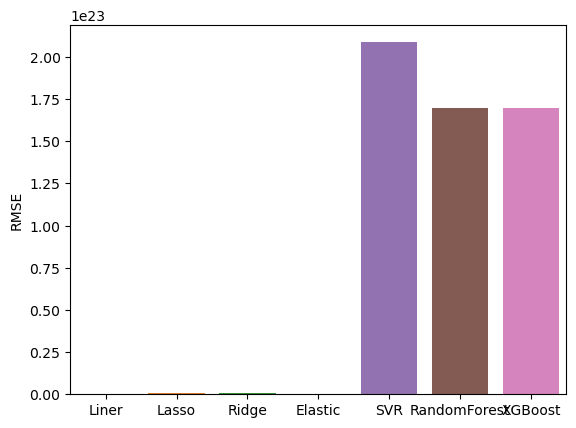

In [47]:
sns.barplot(result.index,result.RMSE)

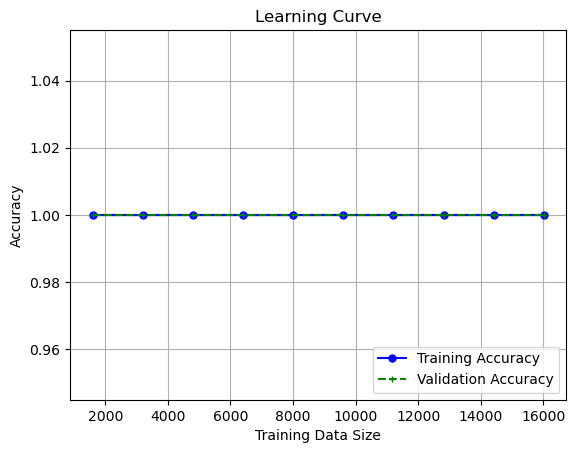

In [48]:
from sklearn.model_selection import learning_curve
# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe, 
    X=X_train, 
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=1,
    cv=5
)

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save the model
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

# Save the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Save the score
pickle.dump(score, open('score.pkl', 'wb'))

# Save the learning rate
pickle.dump(learning_rate, open('learning_rate.pkl', 'wb'))

# Save the columns
pickle.dump(data.drop('Year', axis = 1).columns, open('columns.pkl', 'wb'))

# Save the year
pickle.dump(data['Year'].values, open('year.pkl', 'wb'))

# Save the data
pickle.dump(data, open('data.pkl', 'wb'))